# Esercitazione I
1. Implementare la regressione logistica da zero, utilizzando gli stessi dati del _notebook 1_.
2. Implementare la regressione softmax da zero utilizzando il trucco **log-sum-exp**.

## Regressione Logistica

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Generazione dei dati

In [51]:
X, y = make_classification(n_samples=200, n_features=1, n_informative=1,
                           n_redundant=0, n_clusters_per_class=1,
                           random_state=42)

### Implementazione 

Inizialmente si definisce una classe che implementa il modello di *logistic regression* per la classificazione binaria:

`def __init__` è il costruttore che viene eseguito quando si crea un nuovo oggetto della classe.  

Il **metodo della sigmoide** implementa la funzione di attivazione logistica.

Il **metodo `cost`** implementa la funzione di costo (*loss function*), che in questo caso è l’Entropia Incrociata.  

Il **metodo `fit`**: `m` rappresenta il numero di osservazioni o la cardinalità, mentre `n` è il numero di feature.  
- `self.weights = np.zeros(n)` inizializza il vettore dei pesi con zeri, avente dimensioni pari al numero di feature.  
- `for _ in range(self.iterations):` è il ciclo principale della discesa del gradiente, che ripete l’aggiornamento dei pesi.  
  All’interno del ciclo, `z` calcola il prodotto scalare tra `X` e i pesi `w`, aggiungendo anche il bias, mentre `h` calcola la probabilità, compresa tra 0 e 1, del valore `z`.  
  Per calcolare il gradiente, utilizziamo le formule delle derivate parziali della funzione di costo rispetto a `w` e `b`, dove `(h - y)` misura quanto le previsioni si discostano dai valori reali. Il peso di una feature viene diminuito se `h > y`.  

`self.weights` e `self.bias` applicano la discesa del gradiente:  

  $$
  w := w - \eta \frac{\partial J}{\partial w}
  $$
  $$
  b := b - \eta \frac{\partial J}{\partial b}
  $$

  dove $\eta$ è il *learning rate* e determina la velocità di aggiornamento dei parametri.  
  `dw` e `db` rappresentano le direzioni in cui il costo cresce, pertanto vengono sottratti per muoversi verso il minimo.  

La *loss* viene salvata con `self.cost_history.append(self.cost(h, y))`, in modo da tenere traccia del suo valore a ogni iterazione. Ciò è utile per rappresentarla graficamente e verificare se la discesa del gradiente converge.  

Il **metodo `predict`** calcola $p = \sigma(Xw + b)$, ossia la probabilità che un’osservazione appartenga alla classe 1 (detta classe “positiva”), e la confronta con la soglia di 0.5 secondo la regola:

  $$
  \text{Se} \quad p \ge 0.5 \Rightarrow 1, \quad \text{altrimenti} \quad 0
  $$


In [1]:
class LogisticRegressionScratch:
    def __init__(self, learning_rate=0.01, iterations=1000):
        self.lr = learning_rate
        self.iterations = iterations
        self.weights = None
        self.bias = 0
        self.cost_history = []

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def cost(self, h, y):
        m = len(y)
        return - (1/m) * np.sum(y*np.log(h) + (1-y)*np.log(1-h))

    def fit(self, X, y):
        m, n = X.shape
        self.weights = np.zeros(n)

        for _ in range(self.iterations):
            z = np.dot(X, self.weights) + self.bias
            h = self.sigmoid(z)

            dw = (1/m) * np.dot(X.T, (h - y))
            db = (1/m) * np.sum(h - y)

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

            self.cost_history.append(self.cost(h, y))

    def predict(self, X):
        return (self.sigmoid(np.dot(X, self.weights) + self.bias) >= 0.5).astype(int)

### Addestramento del modello

In [53]:
# Divisione in test e training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizziamo i dati
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [54]:
model = LogisticRegressionScratch(learning_rate=0.1, iterations=1000)
model.fit(X_train, y_train)

### Risultati

In [55]:
# Calcoliamo l'accuracy
predictions = model.predict(X_test)
accuracy = np.mean(predictions == y_test)
print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.97


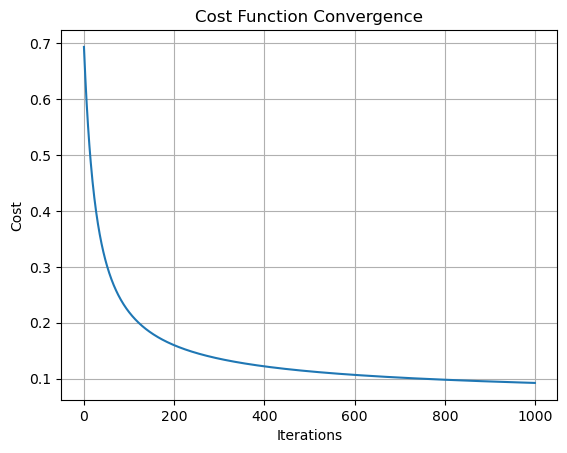

In [56]:
plt.plot(model.cost_history)
plt.title("Cost Function Convergence")
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.grid(True)
plt.show()

# Softmax regression


## Giustificazione teorica del Log-sum-exp

Nella modellazione statistica e nel machine learning, spesso lavoriamo in scala logaritmica. Ci sono molte buone ragioni per farlo.  
Tuttavia, a volte è necessario ridurre i valori generalmente grandi della scala logaritmica. Ad esempio, se dobbiamo normalizzare un vettore di N log-probabilità $x_i = \log{p_i}$, potremmo  calcolare:  
$$ p_i = \frac{exp(x_i)}{\sum_{n=1}^{N}exp(x_n)}, \quad \sum_{n=1}^{N}p_n = 1 $$

Poiché ogni $x_n$ è una log-probabilità che può essere molto grande, sia negativa che positiva, può causare problemi di *underflow* o *overflow*.  
  
Si consideri inoltre che la log-verosimiglianza può assumere scale arbitrarie a seconda della funzione di verosimiglianza e del numero di dati.  

Pertanto, consideriamo l’operazione log-sum-exp:  
$$ LSE(x_1,...,x_N) = \log(\sum_{n=1}^{N}exp(x_n)) $$

... e dopo alcuni passaggi, arriviamo nella forma:  
$$ y = c + \log\sum_{n=1}^{N}\exp(x_n-c) $$

In altre parole, l’operatore log-sum-exp è utile perché possiamo traslare i valori nell’esponente di una costante arbitraria *c* pur ottenendo lo stesso valore finale. Se impostiamo:  
$$ c = \max\{x_1, ..., x_N\} $$  
ci assicuriamo che il termine positivo più grande esponenziato sia  
$$ \exp(0) = 1 $$

[Fonte della spiegazione](https://gregorygundersen.com/blog/2020/02/09/log-sum-exp/)

```python

def logsumexp(x):
    c = x.max()
    return c + np.log(np.sum(np.exp(x - c)))


## Implementazione 

In [ ]:
class SoftmaxRegression:
    """
   Implementa la regressione Softmax 
   Utilizzando il trucco Log-Sum-Exp per un calcolo delle perdite numericamente stabile.
    """
    
    # Initialization 
    def __init__(self, 
                 learning_rate=0.01, 
                 n_epochs = 1000,
                 l2 = 1):
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.w = None  
        self.l2 = l2
        self.losses = [] 
        
    # Passo di One-Hot Encoding 
    def one_hot_encode(self, y: pd.Series): 
        """Converte le etichette di classe in una matrice codificata one-hot."""
        if isinstance(y, pd.Series):
             y = y.to_numpy()
        
        # Get the number of unique classes (K)
        K = np.unique(y).size
        
        return np.eye(K)[y]

    # Forma numericamente stabile di softamx
    def softmax(self, scores: np.ndarray):
        """
        Calcola le probabilità softmax utilizzando il trucco della normalizzazione 
        """
        stable_scores = scores - np.max(scores, axis=1, keepdims=True)
        
        exp_scores = np.exp(stable_scores)
        
        probabilities = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        
        return probabilities

    # La funzione di log(sum(exp(x_i))) 
    def logsumexp(self, scores: np.ndarray):
        """Applica la Log-Sum-Exp trick"""
        c = np.max(scores, axis=1, keepdims=True)
        return c + np.log(np.sum(np.exp(scores - c), axis=1, keepdims=True))

    # Fit Method 
    def fit(self, X: pd.DataFrame, y: pd.Series):
        
        X_data = X.to_numpy() if isinstance(X, pd.DataFrame) else X
        y_data = y.to_numpy() if isinstance(y, pd.Series) else y

        m, n = X_data.shape # m=samples, n=features
        y_mat = self.one_hot_encode(y_data)
        K = y_mat.shape[1]
        
        # Pesi (n x K) 
        self.w = np.zeros([n, K]) 

        for epoch in range(self.n_epochs):
            
            # I calcoli degli scores
            score = np.dot(X_data, self.w)

            # Le probabilita' di softmax
            prob = self.softmax(score)
            
            # Calcolo di log-sum-exp degli scores: log(sum(exp(S)))
            log_sum_exp_scores = self.logsumexp(score) 

            # Calcoli degli score per la true class: sum(Y * S)
            correct_score = np.sum(y_mat * score, axis=1, keepdims=True)

            # Negative Log Likelihood (NLL) per ogni esempio 
            nll_loss_samples = log_sum_exp_scores - correct_score
            
            # Total Mean Loss (J)
            data_loss = np.sum(nll_loss_samples) / m
            reg_loss = (self.l2 / 2) * np.sum(self.w * self.w)
            
            loss = data_loss + reg_loss
            self.losses.append(loss)
            
            # Calcolo del gradiente (G) 
            grad = (-1 / m) * np.dot(X_data.T, (y_mat - prob)) + (self.l2 * self.w)

            # Weight Update
            self.w = self.w - (self.learning_rate * grad)
            
        return self

    # Metodo di previsione
    def predict(self,
                X:pd.DataFrame):
        """Prevede probabilità ed etichette di classe."""
        
        X_data = X.to_numpy() if isinstance(X, pd.DataFrame) else X
        
        # Probs
        probs = self.softmax(np.dot(X_data, self.w))
        
        # Preds
        preds = np.argmax(probs, axis=1)
        return probs, preds

    # Calcolo di accuracy
    @staticmethod # metodo, appartiene alla classe piuttosto che all'istanza
    def accuracy(actual:list, pred:list):
        """Calcola l'accuratezza della previsione."""
        actual = np.array(actual)
        pred = np.array(pred)

        assert len(actual) == len(pred)
        return (np.sum(actual == pred) / len(actual))

`def __init__` di nuovo serve per inizializzare i parametri principali del modello di regressione `softmax`.\
 Quando viene creata un’istanza della classe, vengono impostati tre valori: 
 - il tasso di apprendimento `learning_rate`, 
 + il parametro di regolarizzazione `l2`, che serve a penalizzare pesi troppo grandi e per evitare l'overfitting.
 + inizializza i pesi `w` a `None` perché verranno creati successivamente durante il training, e prepara una lista vuota `losses` per salvare l’andamento della funzione di costo nel tempo.

- La funzione `one_hot_encode` trasforma le etichette in una codifica `one-hot`

- La funzione `softmax` calcola le probabilità normalizzate di ciascuna classe 
    + La funzione `logsumexp` calcola in maniera stabile il logaritmo della somma degli esponenziali dei punteggi

>Il **Log-Sum-Exp trick** consiste nel sottrarre dal vettore dei punteggi il valore massimo `c` prima di calcolare gli esponenziali. Questa riformulazione sfrutta il fatto che $(\exp(s_k - c) \le 1)$ per ogni $(k)$, garantendo che la somma degli esponenziali rimanga in un intervallo numericamente stabile. Il termine (c) viene poi aggiunto di nuovo alla fine per mantenere il valore corretto della funzione logaritmica. 

    
- Il metodo `fit` si occupa dell’addestramento del modello

- Il metodo `predict` calcola le probabilità e restituisce le predizioni scegliendo la classe con probabilità massima. 

- Il metodo statico `accuracy` confronta le predizioni con i valori reali e restituisce la percentuale di correttezza. 

## Classificazione del dataset Iris

In [58]:
from sklearn.datasets import load_iris
iris = load_iris()

X_df = pd.DataFrame(iris.data, columns=iris.feature_names)
y_series = pd.Series(iris.target)

X_train_df, X_test_df, y_train, y_test = train_test_split(X_df, y_series, 
                                                          test_size=0.2, 
                                                          random_state=42)

scaler = StandardScaler()
X_train_np = scaler.fit_transform(X_train_df)
X_test_np = scaler.transform(X_test_df)

model = SoftmaxRegression(learning_rate=0.05, n_epochs=2000, l2=0.01)
model.fit(X_train_np, y_train)

## Risultati

In [59]:
probs, preds = model.predict(X_test_np)
accuracy = (preds == y_test).mean()
print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.93


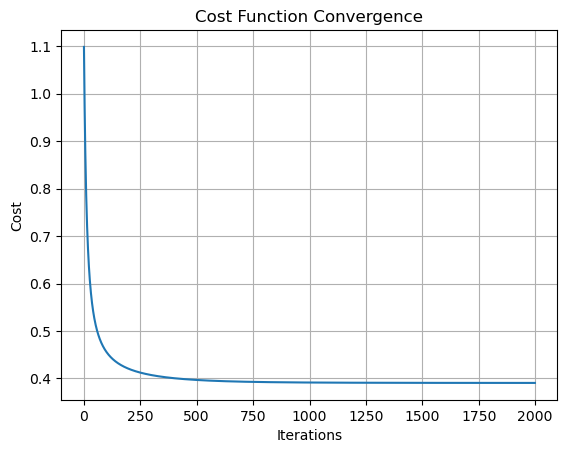

In [60]:
plt.plot(model.losses)
plt.title("Cost Function Convergence")
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.grid(True)
plt.show()

# Referenze
- Per la regressione logistica:
    + https://medium.com/@robdelacruz/logistic-regression-from-scratch-7db690fb380b

- Per la regressione multinomiale:
    + https://medium.com/@arjunprakash027/building-softmax-regression-from-scratch-a-hands-on-guide-with-python-code-5615166c9d4c
    + https://gregorygundersen.com/blog/2020/02/09/log-sum-exp/     